# Capstone Project – Neighborhoods Batlling | Finding a Better Place in Scarborough, Toronto

#### Importing All libraries and Dependensies

In [1]:
!pip install geocoder
!pip install folium

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


#### All the libraries and dependensies are exported

##  2. Data Extraction and Cleaning

In [11]:
wiki = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_page = requests.get(wiki)

wiki_raw = pd.read_html(wiki_page.content, header = 0)[0]
df = wiki_raw[wiki_raw.Neighbourhood != 'Not assigned']
df.reset_index(inplace = True)
df.head()

,index,Postal Code,Borough,Neighbourhood
0,2,M3A,North York,Parkwoods
1,3,M4A,North York,Victoria Village
2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,5,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [12]:
df.groupby(['Postal Code']).first()

,index,Borough,Neighbourhood
Postal Code,,,
M1B,9,Scarborough,"Malvern, Rouge"
M1C,18,Scarborough,"Rouge Hill, Port Union, Highland Creek"
M1E,27,Scarborough,"Guildwood, Morningside, West Hill"
M1G,36,Scarborough,Woburn
M1H,45,Scarborough,Cedarbrae
M1J,54,Scarborough,Scarborough Village
M1K,63,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
M1L,72,Scarborough,"Golden Mile, Clairlea, Oakridge"
M1M,81,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"


In [13]:
len(df['Postal Code'].unique())

103

In [14]:
df[df['Borough'] == 'Not assigned']

,index,Postal Code,Borough,Neighbourhood


In [15]:
df.shape

(103, 4)

In [29]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighbourhood'].tolist()))
                    
grp = df.groupby(['Postal Code', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')
df_2.rename(columns = {'Postal Code':'Postalcode'}, inplace = True)

In [30]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M8Y,North York,Downsview
freq,1,24,4


In [31]:
print(df_2.shape)
df_2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [32]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70909000000006, -79.36409999999995]

In [33]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [34]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [35]:
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493


In [36]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17520
3,M1G,Scarborough,Woburn,43.76820,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76969,-79.23944
5,M1J,Scarborough,Scarborough Village,43.74309,-79.23526
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.72861,-79.26367
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.71406,-79.28412
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.69539,-79.26194


In [38]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="neighbours-Battling")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.773077, -79.257774.


### Map of Scarborough

In [39]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [41]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="neighbor-battling")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [42]:
# @hiddel_cell
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' # my Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET: 1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [43]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [44]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.events.count', 'venue.events.summary', 'venue.id',
       'venue.location.address', 'venue.location.cc', 'venue.location.city',
       'venue.location.country', 'venue.location.crossStreet',
       'venue.location.distance', 'venue.location.formattedAddress',
       'venue.location.labeledLatLngs', 'venue.location.lat',
       'venue.location.lng', 'venue.location.neighborhood',
       'venue.location.postalCode', 'venue.location.state', 'venue.name',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [45]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby locations and Venues

In [46]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
1,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
2,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,DAVIDsTEA,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.776320,-79.258688
4,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.776410,-79.258069


In [47]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,SEPHORA,Cosmetics Shop,43.775017,-79.258109
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,American Eagle Store,Clothing Store,43.776012,-79.258334
3,DAVIDsTEA,Tea Room,43.776320,-79.258688
4,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069


In [49]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store       10
Coffee Shop           5
Restaurant            4
Gas Station           2
Sandwich Place        2
Tea Room              2
Pharmacy              2
Shopping Mall         1
Toy / Game Store      1
Fish & Chips Shop     1
Name: categories, dtype: int64

In [50]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [51]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [52]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 299 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,34,34,34,34,34,34
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",4,4,4,4,4,4
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26


### One hot encoding of features

In [53]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Rest

In [54]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                  venue  freq
0    Chinese Restaurant  0.09
1         Shopping Mall  0.09
2  Hong Kong Restaurant  0.03
3          Skating Rink  0.03
4      Malay Restaurant  0.03


---- Alderwood, Long Branch ----
            venue  freq
0      Print Shop  0.14
1     Pizza Place  0.14
2     Gas Station  0.14
3  Sandwich Place  0.14
4             Gym  0.14


---- Bathurst Manor, Wilson Heights, Downsview North ----
                  venue  freq
0                  Park  0.50
1  Other Great Outdoors  0.25
2     Convenience Store  0.25
3                  Pool  0.00
4           Music Store  0.00


---- Bayview Village ----
                     venue  freq
0                     Park  0.25
1                  Dog Run  0.25
2                    Trail  0.25
3         Asian Restaurant  0.25
4  New American Restaurant  0.00


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0     Thai Restaurant  0.08
1      Sandwich Place  0.08
2         Coffee Shop  0.

                       venue  freq
0                Coffee Shop  0.29
1  Latin American Restaurant  0.14
2                  Nightclub  0.14
3             Discount Store  0.14
4                       Café  0.14


---- Humewood-Cedarvale ----
               venue  freq
0      Grocery Store   0.2
1       Tennis Court   0.1
2              Trail   0.1
3  Convenience Store   0.1
4       Hockey Arena   0.1


---- India Bazaar, The Beaches West ----
                  venue  freq
0  Fast Food Restaurant  0.07
1           Coffee Shop  0.07
2               Brewery  0.07
3                  Café  0.07
4                Bakery  0.07


---- Islington Avenue, Humber Valley Village ----
                 venue  freq
0             Pharmacy  0.17
1    Convenience Store  0.08
2  Japanese Restaurant  0.08
3                 Café  0.08
4         Skating Rink  0.08


---- Kennedy Park, Ionview, East Birchmount Park ----
                venue  freq
0         Coffee Shop  0.18
1  Chinese Restaurant  0.12
2       

         venue  freq
0  Coffee Shop  0.07
1         Café  0.06
2          Bar  0.05
3        Diner  0.05
4       Bakery  0.05


---- Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park ----
                 venue  freq
0          Coffee Shop  0.10
1                  Pub  0.10
2         Skating Rink  0.10
3       Sandwich Place  0.05
4  Fried Chicken Joint  0.05


---- The Annex, North Midtown, Yorkville ----
                venue  freq
0      Sandwich Place  0.08
1  Italian Restaurant  0.08
2                Café  0.06
3                 Gym  0.06
4  Mexican Restaurant  0.06


---- The Beaches ----
             venue  freq
0              Pub  0.08
1              Bar  0.08
2  Thai Restaurant  0.04
3        Juice Bar  0.04
4      Cheese Shop  0.04


---- The Danforth West, Riverdale ----
                  venue  freq
0                  Café  0.17
1        Discount Store  0.08
2      Business Service  0.08
3               Theater  0.08
4  Other Great Outdoors  0.08


---- The 

In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [56]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Discount Store,Latin American Restaurant,Dim Sum Restaurant,Bakery,Bank,Japanese Restaurant,Sushi Restaurant,Supermarket
1,"Alderwood, Long Branch",Sandwich Place,Print Shop,Gym,Pub,Coffee Shop,Pizza Place,Gas Station,Farm,Falafel Restaurant,Event Space
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Other Great Outdoors,Convenience Store,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant
3,Bayview Village,Park,Asian Restaurant,Trail,Dog Run,Yoga Studio,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Pizza Place,Sandwich Place,Restaurant,Thai Restaurant,Italian Restaurant,Pub,Juice Bar,Intersection,Sports Club


### K-Means Clustering Approach

In [57]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 2], dtype=int32)

In [58]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552,1,Zoo Exhibit,Financial or Legal Service,Fast Food Restaurant,Climbing Gym,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871,0,Fish & Chips Shop,Bar,Yoga Studio,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17520,2,Park,Gym / Fitness Center,Athletics & Sports,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant
3,M1G,Scarborough,Woburn,43.76820,-79.21761,2,Park,Chinese Restaurant,Fast Food Restaurant,Coffee Shop,Yoga Studio,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.76969,-79.23944,1,Thai Restaurant,Hakka Restaurant,Gas Station,Caribbean Restaurant,Athletics & Sports,Bakery,Indian Restaurant,Lounge,Flower Shop,Bank


In [59]:
kclusters = 10

In [60]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [61]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [62]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [63]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

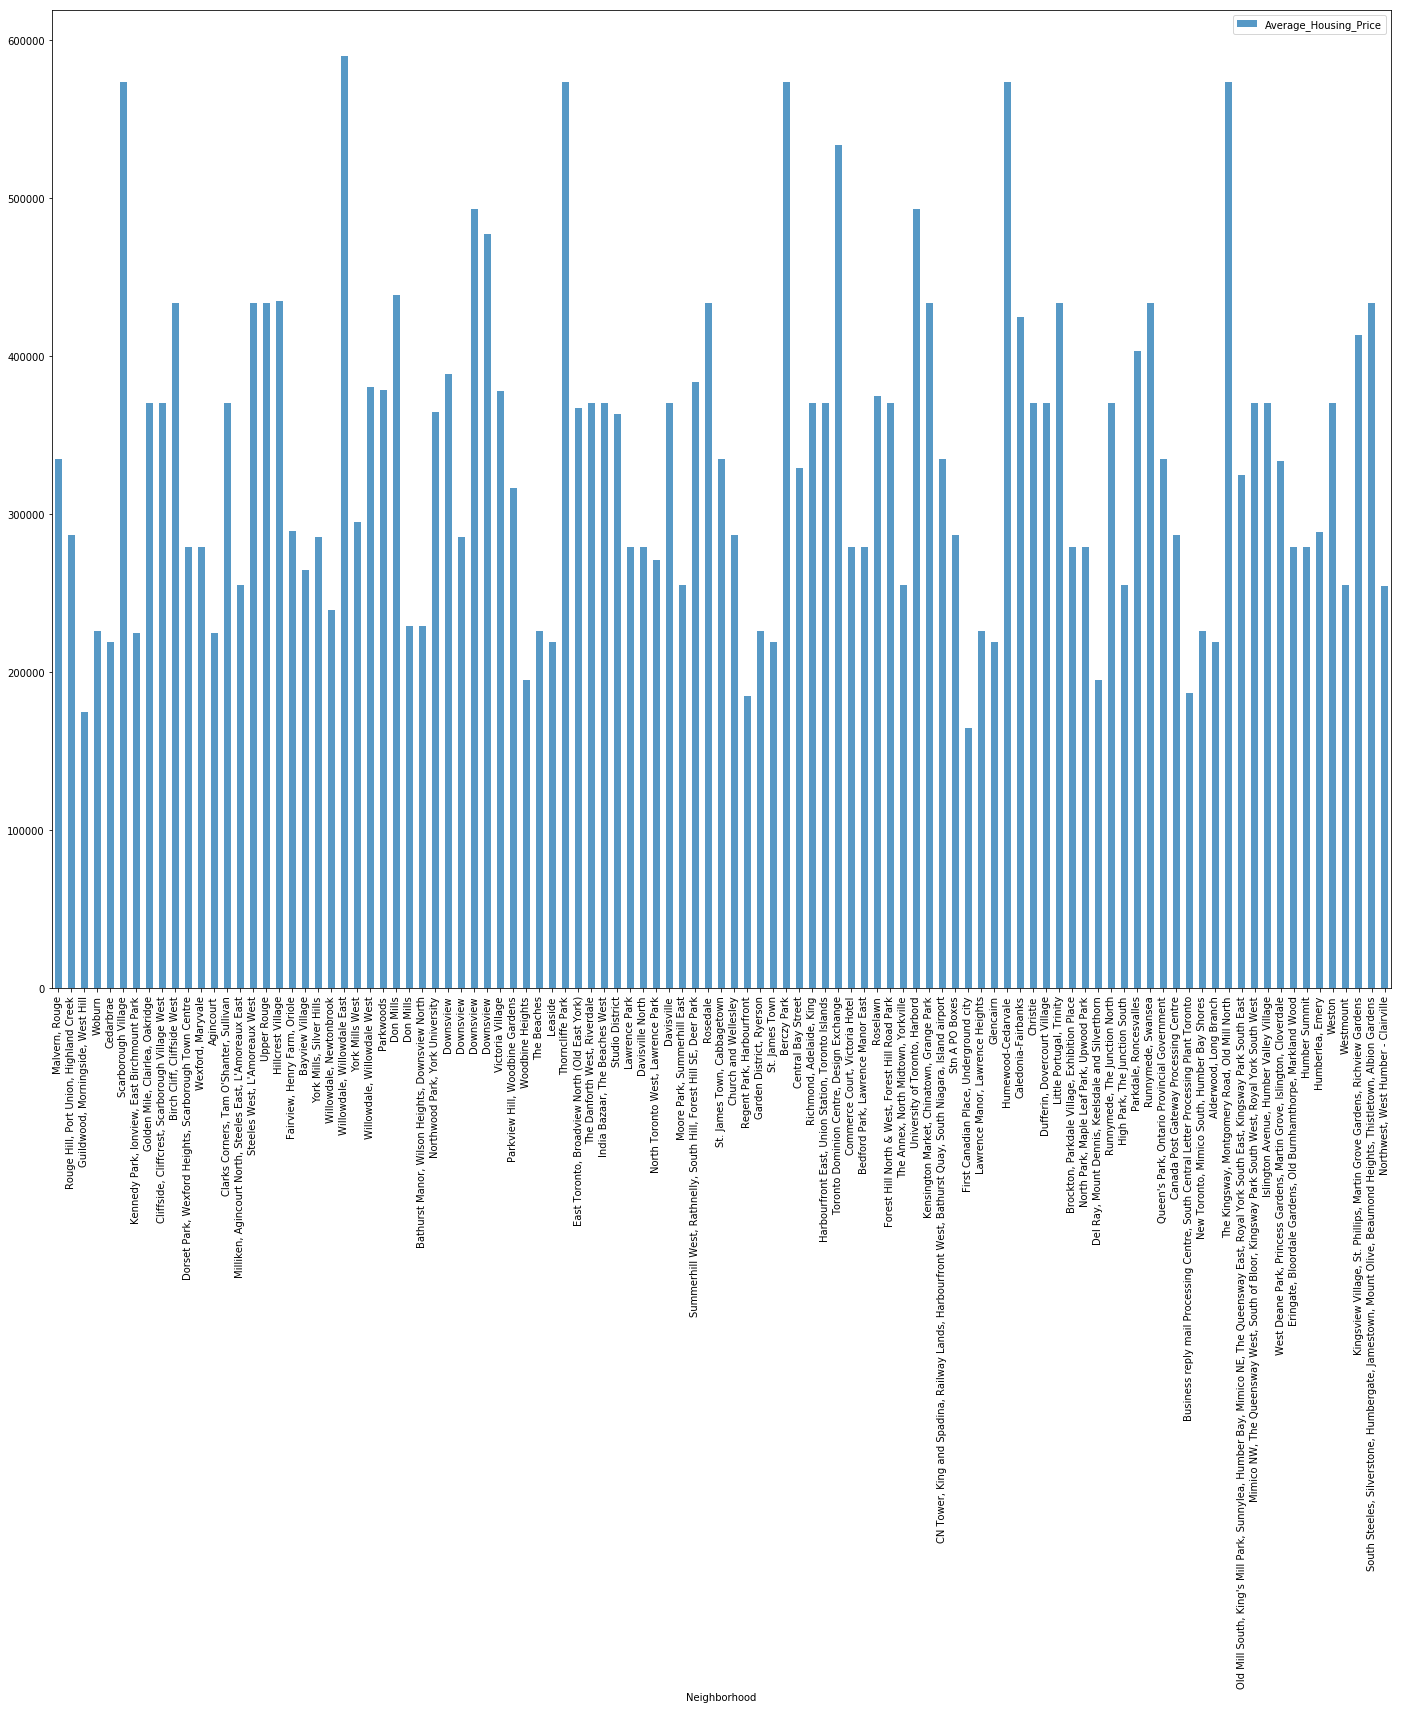

In [64]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### School Rating by Clusters

In [65]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [68]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighbourhood":df["Neighbourhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [70]:
Scarborough_school_ratings.set_index('Neighbourhood',inplace=True,drop=True)

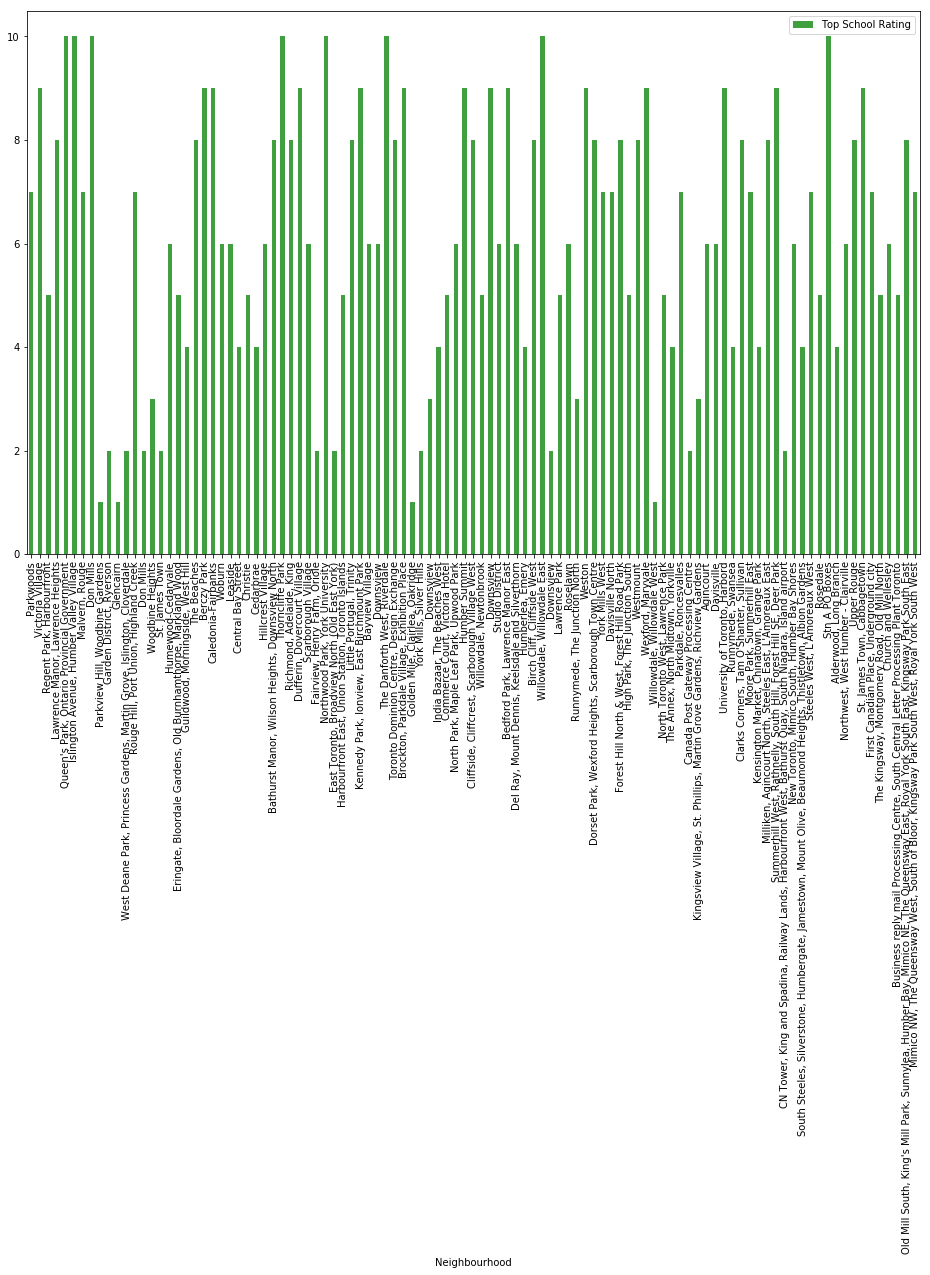

In [71]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

#### Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.